Using device: cpu
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.5MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 462kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.01MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.65MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train (normal 0-4) dataset size : 27537
Validation (normal 0-4) dataset size : 3059
Test (all digits 0-9) dataset size : 10000
Epoch [1/5] - Loss: 423.8764
Epoch [2/5] - Loss: 275.6376
Epoch [3/5] - Loss: 240.8190
Epoch [4/5] - Loss: 222.4444
Epoch [5/5] - Loss: 210.3138
Validation set mean error = 0.228565, std = 0.103384
Chosen threshold = 0.538716

--- TEST RESULTS ---
Precision: 0.9672
Recall   : 0.0850
F1-score : 0.1562
ROC AUC  : 0.8555


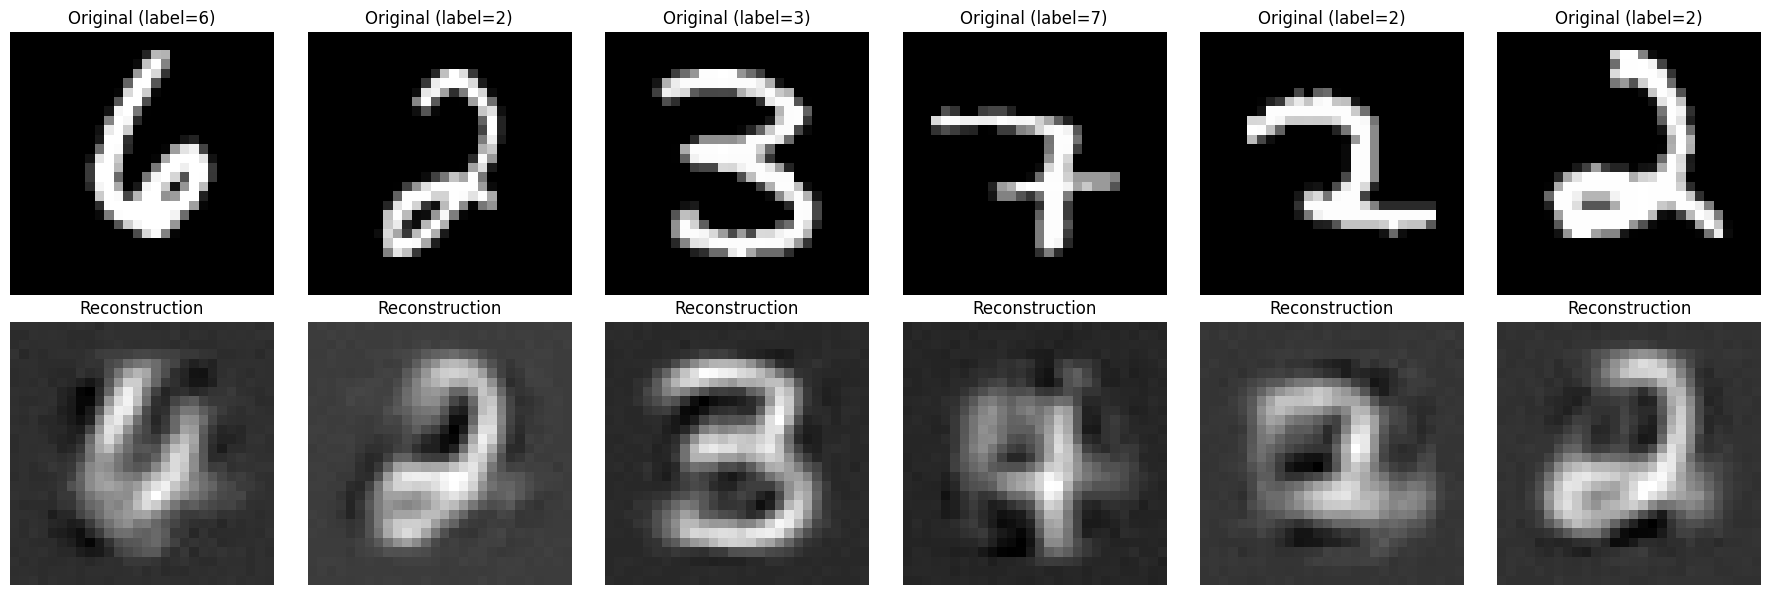

In [ ]:
# ========================
# 1. IMPORTS & SETUP
# ========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ========================
# 2. DATASET PREPARATION
# ========================
# Transform: Convert image to tensor & flatten 28x28=784
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download + Load MNIST
train_dataset = datasets.MNIST(root=".", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=".", train=False, download=True, transform=transform)

# We define "normal" digits as 0-4 and "anomalous" digits as 5-9.
# Let's build subsets accordingly.

# --- Split train set for normal digits only ---
normal_train_indices = [i for i, (img, label) in enumerate(train_dataset) if label in [0,1,2,3,4]]
train_normal_dataset = Subset(train_dataset, normal_train_indices)

# We'll also create a small validation set from the normal train data (e.g., 10%).
val_size = int(0.1 * len(train_normal_dataset))
train_size = len(train_normal_dataset) - val_size

train_normal_dataset, val_normal_dataset = torch.utils.data.random_split(
    train_normal_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# --- Test set: keep both normal (0-4) and anomalous (5-9) digits ---
test_indices = list(range(len(test_dataset)))  # all test data
test_dataset_all = Subset(test_dataset, test_indices)

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_normal_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_normal_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset_all, batch_size=batch_size, shuffle=False)

print(f"Train (normal 0-4) dataset size : {len(train_normal_dataset)}")
print(f"Validation (normal 0-4) dataset size : {len(val_normal_dataset)}")
print(f"Test (all digits 0-9) dataset size : {len(test_dataset_all)}")

# ========================
# 3. VAE MODEL DEFINITION
# ========================
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=16, hidden_dims=[128, 64]):
        super(VAE, self).__init__()
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        decoder_layers = []
        hidden_dims.reverse()  # e.g., [64, 128]
        prev_dim = latent_dim
        for h_dim in hidden_dims:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        self.decoder = nn.Sequential(*decoder_layers)

        # Final output layer to get back to input_dim
        self.final_layer = nn.Linear(hidden_dims[-1], input_dim)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder(z)
        return self.final_layer(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# Initialize model
model = VAE().to(device)

# ========================
# 4. TRAINING SETUP
# ========================
def vae_loss(x, x_hat, mu, logvar):
    """
    1) Reconstruction loss (MSE)
    2) KL divergence
    """
    recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld = kld / x.size(0)
    return recon_loss + kld

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ========================
# 5. TRAINING LOOP
# ========================
def train_vae(model, train_loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, _ in train_loader:
            # Flatten images: (B, 1, 28, 28) -> (B, 784)
            images = images.view(images.size(0), -1).to(device)

            optimizer.zero_grad()
            x_hat, mu, logvar = model(images)
            loss = vae_loss(images, x_hat, mu, logvar)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)

        avg_loss = epoch_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

# Train for a few epochs (feel free to increase for better performance)
train_vae(model, train_loader, num_epochs=5)

# ========================
# 6. VALIDATION & THRESHOLD
# ========================
def compute_reconstruction_errors(model, data_loader):
    model.eval()
    all_errors = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(images.size(0), -1).to(device)
            x_hat, _, _ = model(images)

            # Mean squared error per sample
            mse = F.mse_loss(x_hat, images, reduction='none')
            mse = mse.view(mse.size(0), -1).mean(dim=1)  # average over features
            all_errors.extend(mse.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_errors), np.array(all_labels)

# --- Compute errors on validation set (normal only) to determine threshold
val_errors, val_labels = compute_reconstruction_errors(model, val_loader)
mean_val = val_errors.mean()
std_val = val_errors.std()

# Choose threshold = mean + 3*std (common heuristic)
threshold = mean_val + 3 * std_val
print(f"Validation set mean error = {mean_val:.6f}, std = {std_val:.6f}")
print(f"Chosen threshold = {threshold:.6f}")

# ========================
# 7. TEST EVALUATION
# ========================
# Now compute errors on the test set, containing both normal (0-4) and anomalous (5-9).
test_errors, test_labels = compute_reconstruction_errors(model, test_loader)

# Convert reconstruction errors to binary predictions
# 1 = anomaly if error > threshold, else 0 = normal
test_preds = (test_errors > threshold).astype(int)

# We define normal labels as 0,1,2,3,4 => "normal" => label=0
# and 5,6,7,8,9 => "anomaly" => label=1
# Let's create a binary label array: label=1 if digit >=5, else 0
true_labels_bin = np.array([1 if l >= 5 else 0 for l in test_labels])

# Metrics
precision = precision_score(true_labels_bin, test_preds)
recall = recall_score(true_labels_bin, test_preds)
f1 = f1_score(true_labels_bin, test_preds)
try:
    auc = roc_auc_score(true_labels_bin, test_errors)
except:
    auc = float('nan')

print("\n--- TEST RESULTS ---")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

# ========================
# 8. QUICK VISUALIZATION
# ========================
# Let's visualize a few normal and anomalous reconstructions
model.eval()
num_samples_to_show = 6
indices = np.random.choice(len(test_dataset_all), num_samples_to_show, replace=False)

fig, axes = plt.subplots(2, num_samples_to_show, figsize=(3*num_samples_to_show, 6))

for i, idx in enumerate(indices):
    img, label = test_dataset_all[idx]
    input_img = img.view(1, -1).to(device)

    with torch.no_grad():
        recon, _, _ = model(input_img)

    # Move back to CPU and reshape
    img = img.view(28, 28).cpu().numpy()
    recon = recon.view(28, 28).cpu().numpy()

    # Original
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f"Original (label={label})")
    axes[0, i].axis('off')

    # Reconstruction
    axes[1, i].imshow(recon, cmap='gray')
    axes[1, i].set_title("Reconstruction")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
